In [1]:
from rascal.calibrator import Calibrator
from rascal.util import refine_peaks

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import json

from scipy.signal import find_peaks

C:\Users\Josh\AppData\Local\conda\conda\envs\astro\lib\site-packages\rascal\calibrator.py:19: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
import pkg_resources
import pypeit

In this example, we'll calibrate a spectrum from the DEep Imaging Multi-Object Spectrograph (DEIMOS) instrument on Keck. We load an example calibration spectrum from the `pypeit` library:

In [3]:
data_path = pkg_resources.resource_filename("pypeit", "data/arc_lines/reid_arxiv/keck_deimos_830G.fits")

In [4]:
spectrum = fits.open(data_path)[1].data

This spectrum is from the 830G grating and contains Ne, Ar, Kr arc lines.

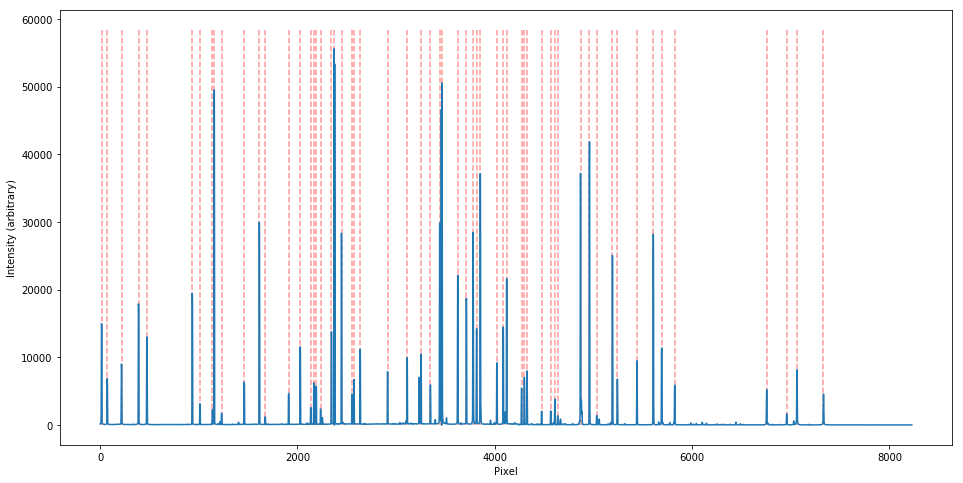

In [5]:
flux = spectrum['flux']

peaks, _ = find_peaks(flux, prominence=1000, distance=20)
refined_peaks = refine_peaks(flux, peaks, window_width=3)

intensity_range = max(flux) - min(flux)
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot("110")
ax.plot(flux)

ax.vlines(refined_peaks,
          0,
          max(flux)+0.05*intensity_range,
          linestyle='dashed',
          alpha=0.4,
          color='red')
plt.xlabel("Pixel")
plt.ylabel("Intensity (arbitrary)")
plt.show()

As this is a reference template, it also has the wavelengths per pixel which we can use to check our calibration solution.

In [6]:
spectrum['wave']

array([ 6501.7978497 ,  6502.25466559,  6502.7114885 , ...,
       10332.98391368, 10333.43598629, 10333.8880502 ])

We'll use this as a hint for the spectral range of the instrument (setting the min/max range). To present a more fair scenario, we pick an approximate min/max and set a tolerance of 500A.

As usual we tell rascal the number of pixels on the detector, a fit tolerance appropriate to the instrument (in this case, we set a slightly lower fit tolerance.

In [7]:
c = Calibrator(refined_peaks, elements = ["Ne", "Ar", "Kr"],
                      min_wavelength=6500,
                      max_wavelength=10400)

c.set_fit_constraints(n_pix=len(spectrum), range_tolerance=100, fit_tolerance=10, polydeg=5)

best_p = c.fit(max_tries=5000)

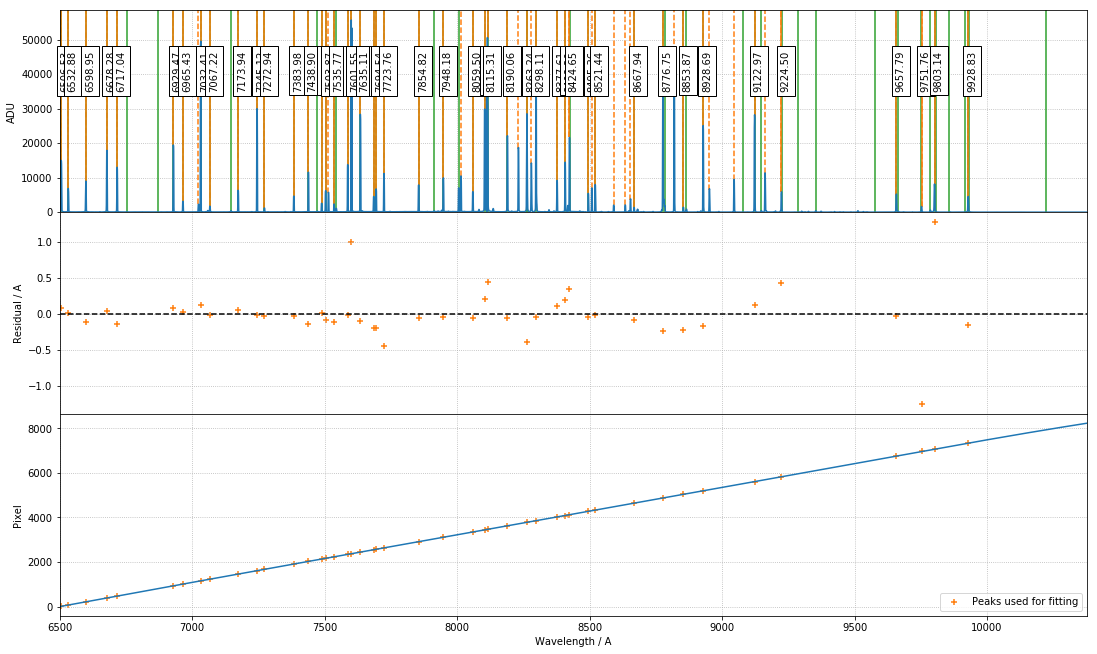

In [10]:
best_p, x_fit, y_fit = c.match_peaks_to_atlas(best_p, polydeg=7, tolerance=3)
c.plot_fit(flux, best_p, plot_atlas=True, log_spectrum=False,tolerance=3)

In [11]:
best_p

array([ 1.25661012e-24, -2.81460912e-20,  2.54186691e-16, -1.19320782e-12,
        2.72756844e-09, -7.40644487e-08,  4.58514396e-01,  6.49985185e+03])

Since we have an existing calibration, we can plot the fit residuals too:

In [12]:
x = c.polyval(best_p, np.arange(len(spectrum)))

In this case, pretty good - some of this error is likely due to peak mismatches. This could be improved using a more appropriate model. The bump is possibly the CCD gap

(-3, 3)

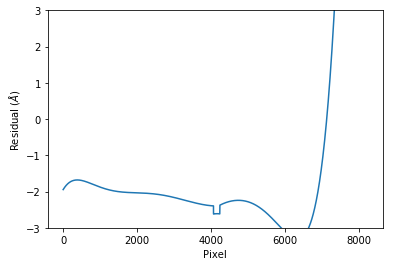

In [15]:
plt.plot(x-spectrum['wave'])
plt.ylabel("Residual ($\AA$)")
plt.xlabel("Pixel")
plt.ylim(-3,3)

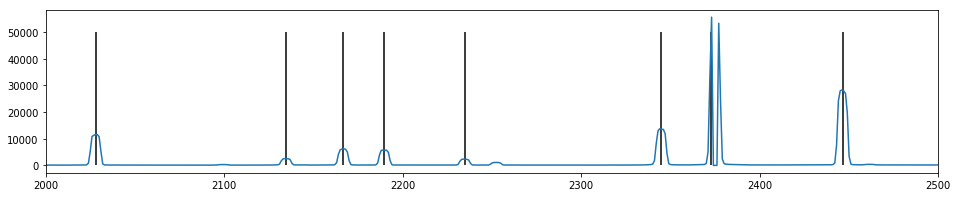

In [29]:
plt.figure(figsize=(16,3))
plt.plot(spectrum['flux'])
plt.xlim(2000,2500)
plt.vlines(refined_peaks,0,50000)